# INF8225


## TP4 Hiver 2020 - Analyse de sentiments sur des reviews de films

##### Membres de l'équipe:

    - Anhoury, Marc (1846809) 
    - Brisebois-Roy, Antoine (1846113) 
    - Arseaneault, Samuel (1850861)
    - Toukal, Monssaf (1850319)

## Installation

Nous avons besoin des librairies `numpy`, `sklearn` et `scipy`, ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

In [1]:
# If you want, you can use anaconda and install after nltk library
# !pip install --user numpy
# !pip install --user sklearn
# !pip install --user scipy
# !pip install --user nltk

import sys
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ImMay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ImMay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ImMay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ImMay\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## Jeu de données

On utilise un jeu de donnée provenant de Stanford.edu: http://ai.stanford.edu/~amaas/data/sentiment/

Pour citer la source originale de la base :

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}

Les données dans cette base de données sont séparées en ensemble d'entrainement et en ensemble de test. En tout, le dataset contient 50 000 reviews de film trouvées sur IMDB, dont 25 000 positives et 25 000 négatives. Sur IMDB, les utilisateurs donnent une note sur 10 aux films. Dans le dataset, les films ayant obtenus un score inférieur ou égal à 4 sont classés comme étant négatifs tandis que les films ayant obtenus un score supérieur ou égal à 7 sont classés comme étant positif. 

Dans le dataset, il peut y avoir un maximum de 30 reviews pour un même film.

Pour les besoins de ce TP, nous avons extrait tous les reviews des fichiers .txt dans un fichier .csv ayant comme première colonne le texte du review et comme deuxième colonne le sentiment (0 pour négatif, 1 pour positif). 



In [2]:
import glob

def create_csv_from_txts(path):
        with open('movies_review.csv', 'w', newline='', encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['Review', 'Sentiment'])
            for cat in ['neg', 'pos']:
                for file in glob.glob(f"{path}/{cat}/*.txt"):
                    with open(file, mode="r", encoding="utf-8") as fd:
                        infos = []
                        content = fd.read()
                        content = content.strip(';')
                        infos.append(content)
                        infos.append(0 if cat == 'neg' else 1)
                        writer.writerow(infos)

In [3]:
# create_csv_from_txts('data') # RUN ONLY ONCE IF NO CSV IN DATA

Nous avons ensuite chargé les données en un ensemble d'entrainement, un ensemble de validation et un ensemble de test. De plus, dès le chargement, nous avons pensé enlever les tags HTML des textes. 

In [3]:
import csv
from sklearn.model_selection import train_test_split
import re

def load_dataset(path):
    
    x = []
    y = []

    with open(path, 'r', newline='', encoding="latin-1") as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        cleanr = re.compile('<.*?>')

        for row in reader:
            x.append(re.sub(cleanr, '', row[0]))
            label = row[1]
            y.append(label)

        assert len(x) == len(y)

        return x, y


# Path of the dataset
path = "data/movies_reviews.csv"

X, y = load_dataset(path)

y = [int(value) for value in y ]

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))


Length of training set :  34850
Length of validation set :  7650
Length of test set :  7500


## Prétraitement

Nous avons implémenter la *tokenization* et le *stemming*, qui sont 2 étapes courantes de preprocessing en NLP.

### Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple la phrase *"It's the student's notebook."* peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].

De plus, dans notre code, nous avons pris l'initiative d'enlever du tableau de *tokens* tous les signes de ponctuations pour ne pas avoir d'information supperflue.

**De plus, tous les tokenizers ont également le rôle de mettre le texte en minuscule.**


- Le **NLTKTokenizer**, qui utilise la méthode du package *nltk* (https://www.nltk.org/api/nltk.html).


In [4]:
from nltk.tokenize import TweetTokenizer
import string

class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        review_tknzr = TweetTokenizer()
        # Have to return a list of tokens
        tokens = review_tknzr.tokenize(text)
        tokens = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
        tokens = [s for s in tokens if s]
        return tokens


In [5]:
nltk_tknzr = NLTKTokenizer()
test = train_X[1]
nltk_tokens = nltk_tknzr.tokenize(test)
print(nltk_tokens)



['Im', 'warning', 'you', 'people', 'out', 'there', 'this', 'is', 'just', 'a', 'waste', 'of', 'your', 'time', 'I', 'am', 'being', 'honest', 'when', 'Im', 'saying', 'that', 'this', 'is', 'the', 'worst', 'movie', 'Ive', 'ever', 'seen', 'Its', 'just', 'a', 'move', 'about', 'Christian', 'propaganda', 'Dont', 'throw', 'away', 'your', 'life', 'dont', 'see', 'it', 'I', 'think', 'they', 'made', 'the', 'movie', 'so', 'more', 'people', 'will', 'believe', 'in', 'Jesus', 'or', 'something', 'but', 'it', 'works', 'in', 'the', 'opposite', 'way', 'The', 'actors', 'are', 'all', 'newbies', 'the', 'story', 'is', 'just', 'fuzzy', 'I', 'think', 'this', 'movie', 'is', 'a', 'work', 'of', 'the', 'devil', 'This', 'movie', 'is', 'just', 'not', 'worth', 'seeing', 'so', 'please', 'take', 'my', 'advice', 'and', 'dont']


### Troncature (ou Stemming)

Permet de conserver seulement la racine des mots sans "overhead".

In [6]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, token):
        """
        token: a string that contain a token
        """
        stem_token = self.stemmer.stem(token)
        return stem_token


In [7]:
snow_stemmer = Stemmer()

for token in nltk_tokens:
    print(token, " : ", snow_stemmer.stem(token))


Im  :  im
you  :  you
people  :  peopl
out  :  out
there  :  there
this  :  this
is  :  is
just  :  just
a  :  a
waste  :  wast
of  :  of
your  :  your
time  :  time
I  :  i
am  :  am
being  :  being
honest  :  honest
when  :  when
Im  :  im
saying  :  say
that  :  that
this  :  this
is  :  is
the  :  the
worst  :  worst
movie  :  movi
Ive  :  ive
ever  :  ever
seen  :  seen
Its  :  its
just  :  just
a  :  a
move  :  move
about  :  about
Christian  :  christian
propaganda  :  propaganda
Dont  :  dont
throw  :  throw
away  :  away
your  :  your
life  :  life
dont  :  dont
see  :  see
it  :  it
I  :  i
think  :  think
they  :  they
made  :  made
the  :  the
movie  :  movi
so  :  so
more  :  more
people  :  peopl
will  :  will
believe  :  believ
in  :  in
Jesus  :  jesus
or  :  or
something  :  someth
but  :  but
it  :  it
works  :  work
in  :  in
the  :  the
opposite  :  opposit
way  :  way
The  :  the
actors  :  actor
are  :  are
all  :  all
newbies  :  newbi
the  :  the
story  :  stori

### Pipeline

Un pipeline permet d'exécuter séquentiellement toutes les étapes de preprocessing, pour transformer les données brutes en une version utilisable pour notre modèle. La *PreprocessingPipeline* a été implémenter pour appliquer à la suite le tokenizer et les troncatures.

In [8]:
happy_emoji = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

sad_emoji = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

def replace_emoji(token):
    if token in happy_emoji:
        return ":)"
    if token in sad_emoji:
        return ":("
    
    return token

In [9]:
class LinkPreprocessing(object):

    def preprocess(self, tokens):
        """
        tokens: original list of tokens
        """
        removed_chars = ["http", "@"] # Utilisation de list si jamais on veux ajouter des conditions
        new_tokens = [replace_emoji(token) for token in tokens if not any(character in token.lower() for character in removed_chars)]

        # return the preprocessed twitter
        return new_tokens

In [10]:
class PreprocessingPipeline:

    def __init__(self, stemming):
        """
        tokenization: enable or disable tokenization.
        emojiPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer = NLTKTokenizer()
        self.linkPreprocesser = LinkPreprocessing()
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, review):
        """
        Transform the raw data

        tokenization: boolean value.
        stemming: boolean value.
        """

        tokens = self.tokenizer.tokenize(review)

        if self.stemmer:
            tokens = list(map(self.stemmer.stem, tokens))
        
        tokens = self.linkPreprocesser.preprocess(tokens)
        
        return tokens

Test de la pipeline :

In [30]:
pipeline = PreprocessingPipeline(stemming=True)
print(train_X[:1])
print(list(map(pipeline.preprocess, train_X[:1])))

['When I first saw the trailer for The Comebacks, it looked absolutely horrible and I had no interest in seeing it, but when it came out on DVD today, I figured since there was nothing else that caught my interest, I would rent it and give it a shot. I watched it tonite and it really wasn\'t that bad. I think it was immature and stupid at times, but there were a few funny moments that made me laugh. I don\'t really watch many sports movies, so I wonder maybe if I saw more, maybe this movie would make more sense to me, but it\'s all good, I still didn\'t mind so much watching The Comebacks. I admit, these "stupid spoof" movies are lame, but what\'s the harm in a stupid joke every once in a while? The Comebacks isn\'t really that bad if you give it a fair chance.Coach Fields is failing in life, family and career both, but when he is offered a chance to bring his career back to life if he can bring a looser football team into the championship. But the team is really really terrible, like 

## Extraction des caractéristiques (features)

Les méthodes suivantes permettent de transformer les textes en vecteurs utilisables pour la classification.

### N-grams

Une des approches répandues dans le traitement de la langue naturelle est le modèle N-Gram. Pour faire court, N-Gram est un modèle probabiliste qui a pour but de prédire le prochain élément dans une chaîne de N éléments (par exemple, de n mots précédents). Un élément peut être une lettre, une syllabe ou encore un mot. En fait, la méthode N-Gram est une forme de modèle de Markov: afin d’effectuer une prédiction, il faut se baser uniquement sur les éléments précédents de la chaîne. Il y a plusieurs variantes de N-Gram: uni-gram, bi-gram, tri-gram, etc.

Voici la liste de tous les unigrams, bigrams et trigrams possible pour la phrase *"Il nous a dit au revoir en franchissant la porte."* :
- Unigram: ['Il', 'nous', 'a', 'dit', 'au', 'revoir', 'en', 'franchissant', 'la', 'porte']
- Bigram: ['Il nous', 'nous a', 'a dit', 'dit au', 'au revoir', 'revoir en', 'en franchissant', 'franchissant la', 'la porte']
- Trigram: ['Il nous a', 'nous a dit', 'a dit au', 'dit au revoir', 'au revoir en', 'revoir en franchissant', 'en franchissant la', 'franchissant la porte']

### Bag-of-words

Bag-of-words est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construit en comptant le nombre d'occurence de chaque mot. Ainsi, chaque token est ici associé à une dimension.

### TF-IDF

Nous avons utilisé TF-IDF pour être capable de pondérer chaque mot dans un review, car nous savons tous qu'il y a des mots qui sont plus importants que d'autre pour déterminer si une review est négative ou positive.

## Classification

Nous avons testé exhaustivement plusieurs types de classificateurs: un par régression logistique, un par descente du gradient (SGD), un par *Support Vector Machine* (SVM), un par Bayes Naïf et un par foret aléatoire.

## Pipeline de traitement

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def get_pipeline(classifier, tokenizer=None, preprocessor=None, ngram_range=(1, 2), use_idf=True):
    return Pipeline([
        ('count_vectorizer',   CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, ngram_range=ngram_range, max_df=0.5)),
        ('tfidf_transformer',  TfidfTransformer(smooth_idf=True, use_idf=use_idf)),
        ('classifier',          classifier)
        ])

## Fonctions d'évaluation

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_test,y_predicted,label_names):
    cm = confusion_matrix(y_test, y_predicted)

    figsize = (10,7)
    df_cm = pd.DataFrame(
        cm, index=label_names, columns=label_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def evaluate_classifier(pipeline, x_test, y_test):
    y_predicted = pipeline.predict(x_test)
    report  = get_classifier_scores(y_test, y_predicted)
    plot_confusion_matrix(y_test, y_predicted, ["negatif", "positif"])
    return report

def get_classifier_scores(real, pred):
    return {
        "accuracy":accuracy_score(real, pred),
        "f1_score":f1_score(real, pred),
        "precision":precision_score(real, pred),
        "recall":recall_score(real, pred)
    }


In [13]:
from tqdm import tqdm_notebook as tqdm
def evaluate_all_pipelines(x_train, y_train, x_valid, y_valid, classifiers, tokenizers, ngrams, use_idfs):

    results = {}
    total_iterations = len(classifiers)*len(tokenizers)*len(ngrams)*len(use_idfs)
    with tqdm(total = total_iterations) as progress:
        for classifier_name, classifier in classifiers:
            results[classifier_name] = []
            for tokenizer_name, tokenizer in tokenizers:
                for ngram in ngrams:
                    for use_idf in use_idfs:
                        idf_string = "tfidf" if use_idf else "bag of words"
                        metaparams =(tokenizer_name, ngram, idf_string) 
                        progress.write(f"Processing : {metaparams} for {classifier_name}")
                        
                        pipeline = get_pipeline(classifier, tokenizer=tokenizer, ngram_range = ngram, use_idf = use_idf)
                        pipeline.fit(x_train, y_train)
                        y_predict = pipeline.predict(x_valid)
                        result = get_classifier_scores(y_valid, y_predict)
                        results[classifier_name].append({
                         "result": result,
                         "Metaparams":metaparams,
                         "pipeline":pipeline
                        })
                        
                        progress.update(1)
    
    return results

## Entraînement des classificateurs

In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression


classifiers = [("Logistic", LogisticRegression()), 
               ("SGD", SGDClassifier(random_state=42, max_iter=5)),
               ("SVM", NuSVC()),
               ("Naive Bayes",BernoulliNB()),
               ("Random Forest", RandomForestClassifier(n_estimators=500))]
tokenizer_stem = PreprocessingPipeline(stemming=True)
tokenizers = [("Default", None), ("Our Tokenizer", tokenizer_stem.preprocess),]
ngrams = [(1,1), (1,2)]
use_idfs =[False, True]

results = evaluate_all_pipelines(train_X, train_Y, valid_X, valid_Y, classifiers, tokenizers, ngrams, use_idfs)


Processing : ('Default', (1, 1), 'bag of words') for Logistic


D:\Users\ImMay\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Processing : ('Default', (1, 1), 'tfidf') for Logistic
Processing : ('Default', (1, 2), 'bag of words') for Logistic
Processing : ('Default', (1, 2), 'tfidf') for Logistic
Processing : ('Our Tokenizer', (1, 1), 'bag of words') for Logistic
Processing : ('Our Tokenizer', (1, 1), 'tfidf') for Logistic
Processing : ('Our Tokenizer', (1, 2), 'bag of words') for Logistic
Processing : ('Our Tokenizer', (1, 2), 'tfidf') for Logistic
Processing : ('Default', (1, 1), 'bag of words') for SGD


D:\Users\ImMay\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Processing : ('Default', (1, 1), 'tfidf') for SGD
Processing : ('Default', (1, 2), 'bag of words') for SGD
Processing : ('Default', (1, 2), 'tfidf') for SGD
Processing : ('Our Tokenizer', (1, 1), 'bag of words') for SGD
Processing : ('Our Tokenizer', (1, 1), 'tfidf') for SGD
Processing : ('Our Tokenizer', (1, 2), 'bag of words') for SGD
Processing : ('Our Tokenizer', (1, 2), 'tfidf') for SGD
Processing : ('Default', (1, 1), 'bag of words') for SVM


D:\Users\ImMay\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Processing : ('Default', (1, 1), 'tfidf') for SVM
Processing : ('Default', (1, 2), 'bag of words') for SVM
Processing : ('Default', (1, 2), 'tfidf') for SVM
Processing : ('Our Tokenizer', (1, 1), 'bag of words') for SVM
Processing : ('Our Tokenizer', (1, 1), 'tfidf') for SVM
Processing : ('Our Tokenizer', (1, 2), 'bag of words') for SVM
Processing : ('Our Tokenizer', (1, 2), 'tfidf') for SVM
Processing : ('Default', (1, 1), 'bag of words') for Naive Bayes
Processing : ('Default', (1, 1), 'tfidf') for Naive Bayes
Processing : ('Default', (1, 2), 'bag of words') for Naive Bayes
Processing : ('Default', (1, 2), 'tfidf') for Naive Bayes
Processing : ('Our Tokenizer', (1, 1), 'bag of words') for Naive Bayes
Processing : ('Our Tokenizer', (1, 1), 'tfidf') for Naive Bayes
Processing : ('Our Tokenizer', (1, 2), 'bag of words') for Naive Bayes
Processing : ('Our Tokenizer', (1, 2), 'tfidf') for Naive Bayes
Processing : ('Default', (1, 1), 'bag of words') for Random Forest
Processing : ('Default

In [73]:
import copy
best_results = {}
for classifier_name, result_list in results.items():
    result_full = max(result_list, key=lambda res: res["result"]['accuracy'])
    result = copy.deepcopy(result_full['result'])
    result.update({
        'tokenizer':result_full['Metaparams'][0],
        'ngrams':result_full['Metaparams'][1],
        'tf-idf / BoW':result_full['Metaparams'][2]
    })
    best_results[classifier_name] = result

pd.DataFrame.from_dict(best_results, orient='index').sort_values(by=['accuracy'], ascending=False)

,accuracy,f1_score,precision,recall,tokenizer,ngrams,tf-idf / BoW
SGD,0.904314,0.905206,0.892948,0.917805,Our Tokenizer,"(1, 2)",tfidf
Logistic,0.900392,0.900807,0.893134,0.908613,Our Tokenizer,"(1, 2)",tfidf
Random Forest,0.880261,0.878675,0.886424,0.871061,Our Tokenizer,"(1, 2)",tfidf
Naive Bayes,0.878954,0.874797,0.901616,0.849527,Default,"(1, 2)",bag of words
SVM,0.813203,0.792929,0.884578,0.718487,Our Tokenizer,"(1, 2)",tfidf


## Resultats détaillés par classifieur

In [62]:
backup_results_please_dont_delete = copy.deepcopy(results)

In [80]:
def display_classifier_results(selected_classifier, results):
    result_to_display = {}
    for result in results[selected_classifier]:
        result_to_display[str(result['Metaparams'])] = result['result']

    return pd.DataFrame.from_dict(result_to_display, orient='index').sort_values(by=['accuracy'], ascending=False)

### Régression Logistique

In [81]:
current_classifier = "Logistic"
display_classifier_results(current_classifier, results)

,accuracy,f1_score,precision,recall
"('Our Tokenizer', (1, 2), 'tfidf')",0.900392,0.900807,0.893134,0.908613
"('Default', (1, 2), 'tfidf')",0.900131,0.900209,0.895530,0.904937
"('Default', (1, 1), 'tfidf')",0.897386,0.897693,0.891074,0.904412
"('Our Tokenizer', (1, 1), 'tfidf')",0.893725,0.894457,0.884467,0.904674
"('Default', (1, 2), 'bag of words')",0.892680,0.892694,0.888629,0.896796
"('Our Tokenizer', (1, 2), 'bag of words')",0.890327,0.890627,0.884287,0.897059
"('Default', (1, 1), 'bag of words')",0.887582,0.887699,0.882857,0.892595
"('Our Tokenizer', (1, 1), 'bag of words')",0.881046,0.881664,0.873261,0.890231


### Descente Stochastique du Gradient

In [82]:
current_classifier = "SGD"
display_classifier_results(current_classifier, results)

,accuracy,f1_score,precision,recall
"('Our Tokenizer', (1, 2), 'tfidf')",0.904314,0.905206,0.892948,0.917805
"('Default', (1, 2), 'tfidf')",0.903529,0.903630,0.898701,0.908613
"('Default', (1, 1), 'tfidf')",0.898170,0.898686,0.890234,0.907300
"('Default', (1, 2), 'bag of words')",0.894902,0.894544,0.893606,0.895483
"('Our Tokenizer', (1, 1), 'tfidf')",0.894248,0.895356,0.882233,0.908876
"('Our Tokenizer', (1, 2), 'bag of words')",0.893333,0.893667,0.886963,0.900473
"('Default', (1, 1), 'bag of words')",0.883660,0.883994,0.877588,0.890494
"('Our Tokenizer', (1, 1), 'bag of words')",0.882353,0.883299,0.872439,0.894433


### SVM

In [83]:
current_classifier = "SVM"
display_classifier_results(current_classifier, results)

,accuracy,f1_score,precision,recall
"('Our Tokenizer', (1, 2), 'tfidf')",0.813203,0.792929,0.884578,0.718487
"('Our Tokenizer', (1, 1), 'bag of words')",0.811373,0.788695,0.891427,0.707195
"('Default', (1, 1), 'bag of words')",0.788627,0.816020,0.719936,0.941702
"('Default', (1, 2), 'tfidf')",0.775556,0.729564,0.911452,0.608193
"('Our Tokenizer', (1, 1), 'tfidf')",0.743660,0.790379,0.666486,0.970851
"('Default', (1, 1), 'tfidf')",0.719477,0.776365,0.643573,0.978204
"('Our Tokenizer', (1, 2), 'bag of words')",0.714902,0.763372,0.650397,0.923845
"('Default', (1, 2), 'bag of words')",0.672941,0.742857,0.610267,0.949055


### Bayesien Naif (Binomiale)

In [84]:
current_classifier = "Naive Bayes"
display_classifier_results(current_classifier, results)

,accuracy,f1_score,precision,recall
"('Default', (1, 2), 'bag of words')",0.878954,0.874797,0.901616,0.849527
"('Default', (1, 2), 'tfidf')",0.878954,0.874797,0.901616,0.849527
"('Our Tokenizer', (1, 2), 'bag of words')",0.877516,0.874008,0.895564,0.853466
"('Our Tokenizer', (1, 2), 'tfidf')",0.877516,0.874008,0.895564,0.853466
"('Default', (1, 1), 'bag of words')",0.852549,0.847732,0.872222,0.824580
"('Default', (1, 1), 'tfidf')",0.852549,0.847732,0.872222,0.824580
"('Our Tokenizer', (1, 1), 'bag of words')",0.850327,0.846247,0.865897,0.827468
"('Our Tokenizer', (1, 1), 'tfidf')",0.850327,0.846247,0.865897,0.827468


### Forêt aléatoire

In [85]:
current_classifier = "Random Forest"
display_classifier_results(current_classifier, results)

,accuracy,f1_score,precision,recall
"('Our Tokenizer', (1, 2), 'tfidf')",0.880261,0.878675,0.886424,0.871061
"('Default', (1, 2), 'tfidf')",0.877124,0.874633,0.888618,0.861082
"('Default', (1, 2), 'bag of words')",0.876078,0.874967,0.878908,0.871061
"('Our Tokenizer', (1, 2), 'bag of words')",0.874771,0.874509,0.872452,0.876576
"('Our Tokenizer', (1, 1), 'bag of words')",0.866275,0.866187,0.862914,0.869485
"('Default', (1, 1), 'bag of words')",0.865882,0.865460,0.864327,0.866597
"('Default', (1, 1), 'tfidf')",0.865098,0.863347,0.870726,0.856092
"('Our Tokenizer', (1, 1), 'tfidf')",0.859085,0.858382,0.858833,0.857931


## Modèle retenu (meilleure exactitude): SGD

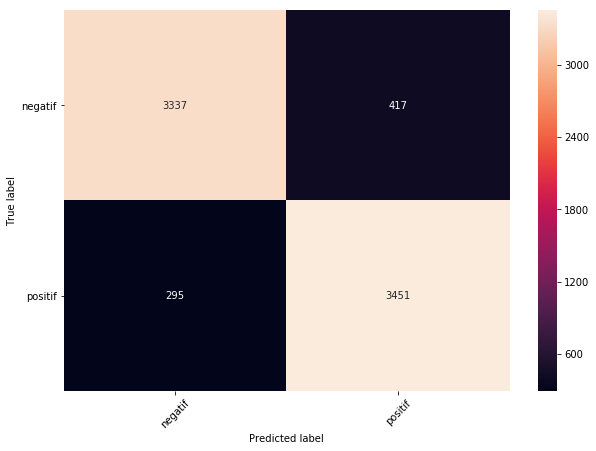

{'accuracy': 0.9050666666666667,
 'f1_score': 0.9064880483320199,
 'precision': 0.8921923474663909,
 'recall': 0.9212493326214629}

In [91]:
best_pipeline = max(results['SGD'], key=lambda res: res["result"]['accuracy'])['pipeline']
evaluate_classifier(best_pipeline, test_X, test_Y)

## Analyse de termes (pas dans l'analyse, car jugé non-intéressant pour l'étude)

In [168]:
import nltk
def is_valid_word_pos(word_pos):
    pos_filter = ["NOUN", "ADJ"]
    
    if word_pos is not None:
        word, pos = word_pos
        return len(word) > 2 and pos in pos_filter
    return False
    
    
def extract_frequent_words(reviews, use_single_words):
    
    frequency_distribution = nltk.FreqDist()
    total_words = 0
    for review in tqdm(reviews):
        pp = PreprocessingPipeline(True)
        tokens = pp.preprocess(review.lower())

        pos_pairs = nltk.pos_tag(tokens, tagset='universal') 
        
        prev_word_pos = None
        prev_prev_word_pos = None
        for word, pos in pos_pairs:
            if is_valid_word_pos((word, pos)):
                if use_single_words:
                    frequency_distribution[word] += 1
                
                if pos == "NOUN" and is_valid_word_pos(prev_word_pos):
                    frequency_distribution["{} {}".format(prev_word_pos[0], word)] += 1
                    if is_valid_word_pos(prev_prev_word_pos):
                        frequency_distribution["{} {} {}".format(prev_prev_word_pos[0],prev_word_pos[0], word)] += 1
            
            prev_prev_word_pos = prev_word_pos
            prev_word_pos = (word, pos)
            
            total_words += 1
    return [(word,"{:.2}%".format(100 *frequency/total_words)) for word, frequency in frequency_distribution.most_common(100)]


In [163]:
from collections import Counter 
positive_reviews = [review for idx, review in enumerate(X) if y[idx]]
negative_reviews = [review for idx, review in enumerate(X) if not y[idx]]
reviews ={
    "positive": positive_reviews[:],
    "negative": negative_reviews[:]
}

In [164]:
import pandas as pd 

review_frequent_words = {}
for sentiment, review in reviews.items():
    review_frequent_words[sentiment] = extract_frequent_words(review, False)

## Termes plus fréquents (excluant les termes singuliers)

In [167]:
pd.DataFrame(review_frequent_words)

,positive,negative
0,"(first time, 0.016%)","(special effect, 0.025%)"
1,"(new york, 0.015%)","(worst movi, 0.019%)"
2,"(main charact, 0.014%)","(main charact, 0.018%)"
3,"(special effect, 0.014%)","(bad movi, 0.016%)"
4,"(same time, 0.013%)","(horror movi, 0.016%)"
5,"(high recommend, 0.011%)","(low budget, 0.015%)"
6,"(great movi, 0.011%)","(horror film, 0.013%)"
7,"(good movi, 0.011%)","(bad guy, 0.013%)"
8,"(horror film, 0.01%)","(only thing, 0.012%)"
9,"(real life, 0.01%)","(good movi, 0.012%)"


In [169]:
review_frequent_words_with_single = {}
for sentiment, review in reviews.items():
    review_frequent_words_with_single[sentiment] = extract_frequent_words(review, True)

## Termes plus fréquents (incluant les termes singuliers)

In [170]:
pd.DataFrame(review_frequent_words_with_single)

,positive,negative
0,"(film, 0.86%)","(movi, 0.96%)"
1,"(movi, 0.73%)","(film, 0.77%)"
2,"(time, 0.27%)","(bad, 0.27%)"
3,"(good, 0.25%)","(time, 0.26%)"
4,"(charact, 0.23%)","(good, 0.25%)"
5,"(great, 0.23%)","(charact, 0.24%)"
6,"(stori, 0.23%)","(scene, 0.19%)"
7,"(other, 0.19%)","(stori, 0.18%)"
8,"(scene, 0.17%)","(other, 0.17%)"
9,"(way, 0.15%)","(thing, 0.16%)"
